**Necessary imports**

In [139]:
import os
import wrds
import pandas as pd
import warnings
import numpy as np
from functools import reduce
warnings.filterwarnings("ignore")

**STEP 1 : data collection from wrds**

In [ ]:
user_name = os.getenv('WRDS_USERNAME')
db = wrds.Connection(wrds_username=user_name)

Loading library list...
Done


In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2000-01-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf['date'] = pd.to_datetime(Rf['date'])

Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#Get the crsp value-weighted return index
query_crsp = """
SELECT date, vwretd, 
FROM crsp.msi
WHERE date BETWEEN '2000-01-01' AND '2024-12-31'
ORDER BY date;
"""

crsp_returns = db.raw_sql(query_crsp)
crsp_returns = crsp_returns.rename(columns={'vwretd': 'us_return'})


crsp_returns.to_csv('data/crsp_return.csv')
Rf.to_csv('data/t_bills_one_month.csv')

OperationalError: (psycopg2.OperationalError) could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out

[SQL: select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2000-01-01'
            and mcaldt<='2024-12-31']
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [193]:
crsp_returns = pd.read_csv('data/crsp_return.csv')

In [167]:
#Interest Rates: 3-Month or 90-Day Rates and Yields: Interbank Rates
ir3_japan = pd.read_csv("data/IR3TIB01JPM156N.csv").rename(columns={"observation_date": "date","IR3TIB01JPM156N" : "ir3_jpn"})
ir3_fra = pd.read_csv("data/IR3TIB01FRM156N.csv").rename(columns={"observation_date": "date","IR3TIB01FRM156N" : "ir3_fra"})
ir3_gb = pd.read_csv("data/IR3TIB01GBM156N.csv").rename(columns={"observation_date": "date","IR3TIB01GBM156N" : "ir3_gb"})
ir3_us = pd.read_csv("data/IR3TIB01USM156N.csv").rename(columns={"observation_date": "date","IR3TIB01USM156N" : "ir3_us"})
ir3_aus = pd.read_csv("data/IR3TIB01AUM156N.csv").rename(columns={"observation_date": "date","IR3TIB01AUM156N" : "ir3_aus"})
ir3_ch = pd.read_csv("data/IR3TIB01CHM156N.csv").rename(columns={"observation_date": "date","IR3TIB01CHM156N" : "ir3_ch"})
ir3_deu = pd.read_csv("data/IR3TIB01DEM156N.csv").rename(columns={"observation_date": "date","IR3TIB01DEM156N" : "ir3_deu"})




def compute_monthly_mean(df, value_col) :
  
    df = df.dropna(subset=[value_col]).copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df[value_col].resample('M').mean()

# JPY: DEXJPUS (JPY per 1 USD) 
df_jpy = pd.read_csv("data/DEXJPUS.csv").rename(columns={"observation_date": "date"})
monthly_jpy_per_usd = compute_monthly_mean(df_jpy, "DEXJPUS")
monthly_jpy_per_usd.name = "JPY_per_USD"

# CHF: DEXSZUS (CHF per 1 USD)
df_chf = pd.read_csv("data/DEXSZUS.csv").rename(columns={"observation_date": "date"})
monthly_chf_per_usd = compute_monthly_mean(df_chf, "DEXSZUS")
monthly_chf_per_usd.name = "CHF_per_USD"

# AUD: DEXUSAL (USD per 1 AUD) 
df_aud = pd.read_csv("data/DEXUSAL.csv").rename(columns={"observation_date": "date"})
df_aud["AUD_per_USD"] = 1 / df_aud["DEXUSAL"]
monthly_aud_per_usd = compute_monthly_mean(df_aud, "AUD_per_USD")

# EUR: DEXUSEU (USD per 1 EUR) 
df_eur = pd.read_csv("data/DEXUSEU.csv").rename(columns={"observation_date": "date"})
df_eur["EUR_per_USD"] = 1 / df_eur["DEXUSEU"]
monthly_eur_per_usd = compute_monthly_mean(df_eur, "EUR_per_USD")

# GBP: DEXUSUK (USD per 1 GBP) 
df_gbp = pd.read_csv("data/DEXUSUK.csv").rename(columns={"observation_date": "date"})
df_gbp["GBP_per_USD"] = 1 / df_gbp["DEXUSUK"]
monthly_gbp_per_usd = compute_monthly_mean(df_gbp, "GBP_per_USD")

files = {
    'jpn': 'data/jpn.csv',
    'aus': 'data/aus.csv',
    'deu': 'data/deu.csv',
    'fra': 'data/fra.csv',
    'ch':  'data/swz.csv',
    'gb':  'data/uk.csv'
}

country_data = {}

for code, path in files.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
 
    return_col = [col for col in df.columns if col != 'date'][0]
    df = df.rename(columns={return_col: f'{code}_return'})
    country_data[code] = df



In [168]:
monthly_all = pd.concat([
    monthly_jpy_per_usd.rename("JPY_per_USD"),
    monthly_chf_per_usd.rename("CHF_per_USD"),
    monthly_aud_per_usd.rename("AUD_per_USD"),
    monthly_eur_per_usd.rename("EUR_per_USD"),
    monthly_gbp_per_usd.rename("GBP_per_USD")
], axis=1)

**Visualizing the data**

<Figure size 800x400 with 0 Axes>

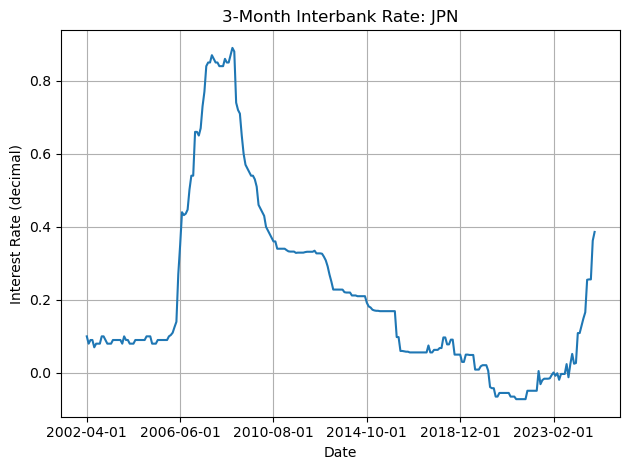

<Figure size 800x400 with 0 Axes>

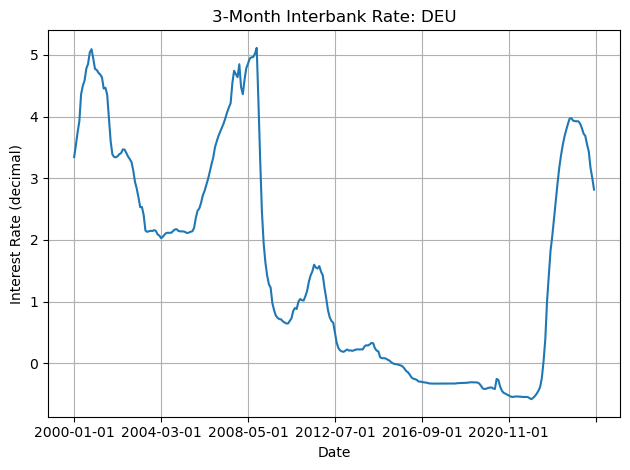

<Figure size 800x400 with 0 Axes>

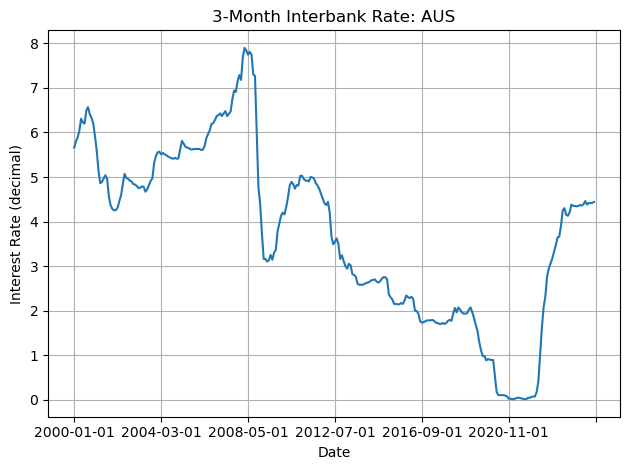

<Figure size 800x400 with 0 Axes>

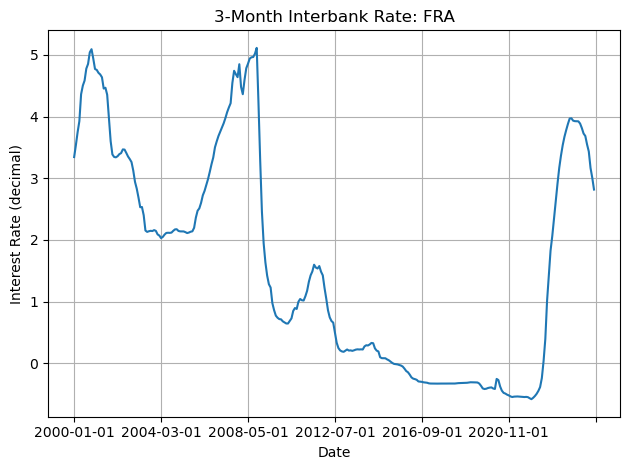

<Figure size 800x400 with 0 Axes>

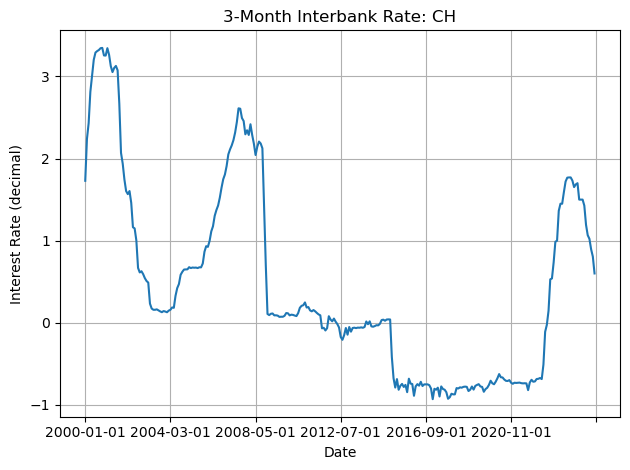

<Figure size 800x400 with 0 Axes>

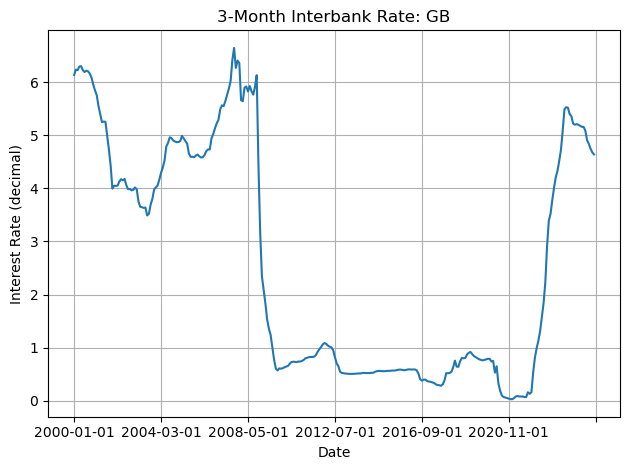

In [169]:
import matplotlib.pyplot as plt
ir3_data = {
    'jpn': ir3_japan,
    'deu': ir3_deu,
    'aus': ir3_aus,
    'fra': ir3_fra,
    'ch': ir3_ch,
    'gb': ir3_gb
}

for country, df in ir3_data.items():
    plt.figure(figsize=(8, 4))
    df.plot(x='date', y=f'ir3_{country}', legend=False)
    plt.title(f'3-Month Interbank Rate: {country.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (decimal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Figure size 1000x400 with 0 Axes>

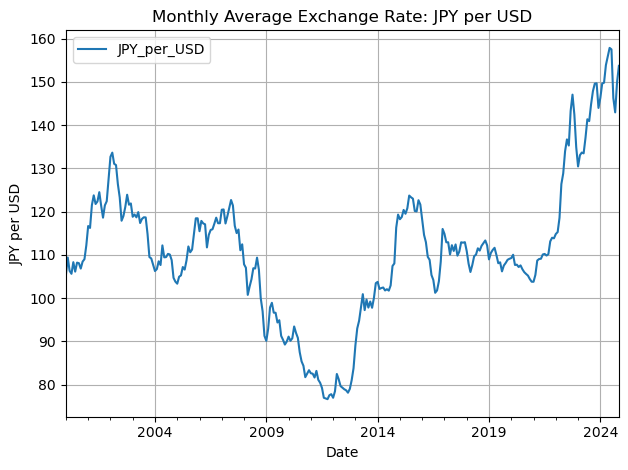

<Figure size 1200x600 with 0 Axes>

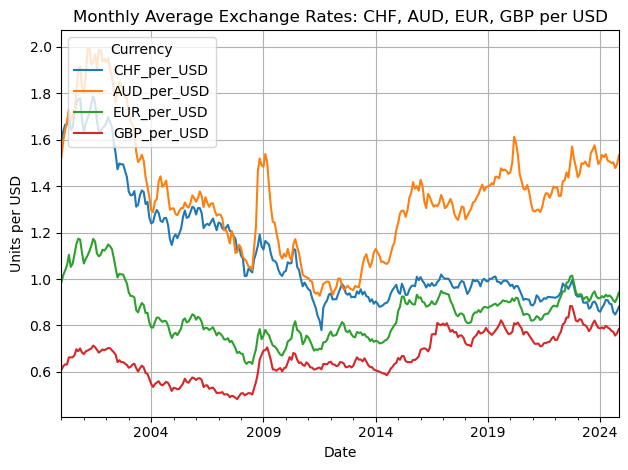

In [170]:
# Separate JPY from others
monthly_jpy = monthly_all[['JPY_per_USD']]
monthly_others = monthly_all.drop(columns='JPY_per_USD')


plt.figure(figsize=(10, 4))
monthly_jpy.plot()
plt.title("Monthly Average Exchange Rate: JPY per USD")
plt.xlabel("Date")
plt.ylabel("JPY per USD")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
monthly_others.plot()
plt.title("Monthly Average Exchange Rates: CHF, AUD, EUR, GBP per USD")
plt.xlabel("Date")
plt.ylabel("Units per USD")
plt.grid(True)
plt.legend(title="Currency", loc="upper left")
plt.tight_layout()
plt.show()

### Foreign Index Return in USD

The formula to convert a foreign index return to USD is:

$$
R_{DC} = (1 + R_{FC}) \cdot (1 + R_{FX}) - 1
$$

Where:

- \( R_{DC} \): Return in domestic currency (USD)  
- \( R_{FC} \): Return in foreign currency  
- \( R_{FX} \): Return on the exchange rate (foreign per USD)


Returns can be expressed as $\log{\frac{R_{t + 1}}{R_t}}$

In [194]:
ret_exchange_rate = np.log(monthly_all/monthly_all.shift(1)) 
ret_exchange_rate.dropna(inplace=True)

def convert_foreign_to_usd(ret_foreign_currency, ret_exchange_rate) :
    return (1 + ret_foreign_currency)*(1 + ret_exchange_rate) - 1  


#Convert for each country

jpn = country_data['jpn']
jpn = jpn.drop(jpn.index[0])
jpn['mportret']  = convert_foreign_to_usd(jpn['mportret'],  ret_exchange_rate['JPY_per_USD'].values)
jpn['mportretx'] = convert_foreign_to_usd(jpn['mportretx'], ret_exchange_rate['JPY_per_USD'].values)


aus = country_data['aus']
aus = aus.drop(aus.index[0])
aus['mportret']  = convert_foreign_to_usd(aus['mportret'],  ret_exchange_rate['AUD_per_USD'].values)
aus['mportretx'] = convert_foreign_to_usd(aus['mportretx'], ret_exchange_rate['AUD_per_USD'].values)


deu = country_data['deu']
deu = deu.drop(deu.index[0])
deu['mportret']  = convert_foreign_to_usd(deu['mportret'],  ret_exchange_rate['EUR_per_USD'].values)
deu['mportretx'] = convert_foreign_to_usd(deu['mportretx'], ret_exchange_rate['EUR_per_USD'].values)


fra = country_data['fra']
fra = fra.drop(fra.index[0])
fra['mportret']  = convert_foreign_to_usd(fra['mportret'],  ret_exchange_rate['EUR_per_USD'].values)
fra['mportretx'] = convert_foreign_to_usd(fra['mportretx'], ret_exchange_rate['EUR_per_USD'].values)


ch = country_data['ch']
ch = ch.drop(ch.index[0])
ch['mportret']  = convert_foreign_to_usd(ch['mportret'],  ret_exchange_rate['CHF_per_USD'].values)
ch['mportretx'] = convert_foreign_to_usd(ch['mportretx'], ret_exchange_rate['CHF_per_USD'].values)


gb = country_data['gb']
gb = gb.drop(gb.index[0])
gb['mportret']  = convert_foreign_to_usd(gb['mportret'],  ret_exchange_rate['GBP_per_USD'].values)
gb['mportretx'] = convert_foreign_to_usd(gb['mportretx'], ret_exchange_rate['GBP_per_USD'].values)



jpn = jpn[['date', 'country', 'mportret', 'mportretx']]
aus = aus[['date', 'country', 'mportret', 'mportretx']]
deu = deu[['date', 'country', 'mportret', 'mportretx']]
fra = fra[['date', 'country', 'mportret', 'mportretx']]
ch  = ch[['date', 'country', 'mportret', 'mportretx']]
gb  = gb[['date', 'country', 'mportret', 'mportretx']]

crsp_returns['country'] = 'US'
crsp_returns['mportretx'] = crsp_returns['vwretd'] - Rf['rf']
crsp_returns = crsp_returns.drop(crsp_returns.index[0])

#Merge
merged_all = pd.concat([jpn, aus, deu, fra, ch, gb, crsp_returns], axis=0, ignore_index=True)


merged_all['date'] = pd.to_datetime(merged_all['date'])


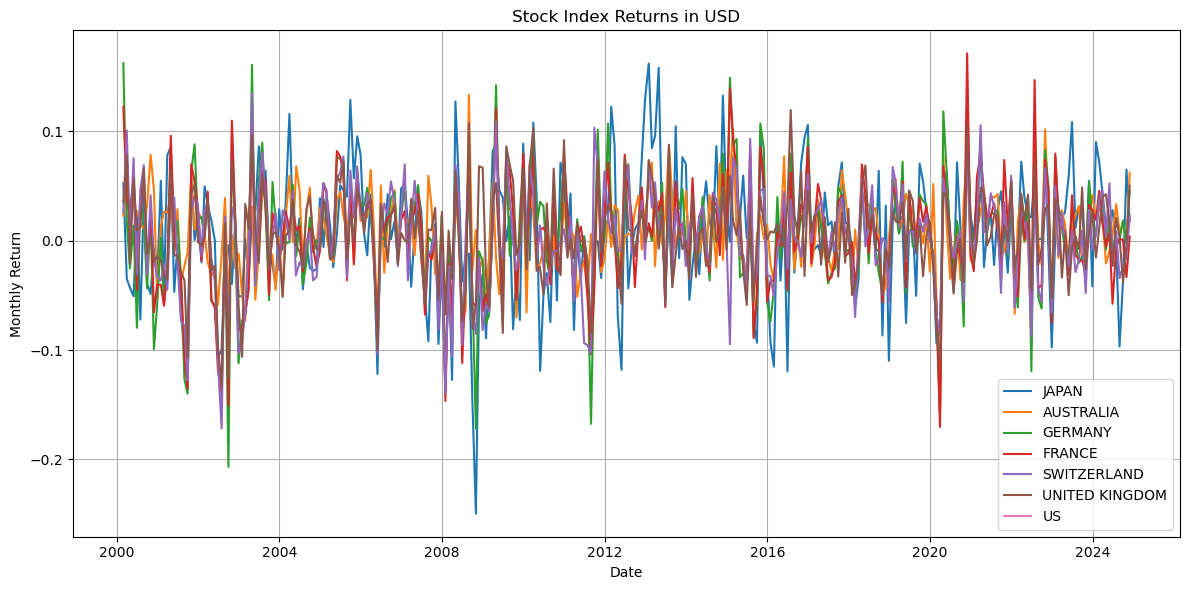

In [195]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in merged_all['country'].unique():
    subset = merged_all[merged_all['country'] == country]
    plt.plot(subset['date'], subset['mportret'], label=country)

plt.title('Stock Index Returns in USD')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()